In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn
import nrrd
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
bpath = '/content/drive/MyDrive/Progetto Applied AI'
dataPath = '/content/drive/MyDrive/Progetto Applied AI/AI Project 2024-2025/Train'
os.chdir(bpath)
print(os.getcwd())

/content/drive/.shortcut-targets-by-id/12wijkop1rAvwc_ED5NKwGvg47V-QZxGN/Progetto Applied AI


In [ ]:
!pip install pynrrd

In [ ]:
slices_paths = glob.glob('**/**/*fullslice.nrrd')
nodules_paths = glob.glob('**/**/*nodule.nrrd')
print(slices_paths)
print(nodules_paths)

['AI Project 2024-2025/Train/pat401_fullslice.nrrd', 'AI Project 2024-2025/Train/pat444_fullslice.nrrd', 'AI Project 2024-2025/Train/pat40_fullslice.nrrd', 'AI Project 2024-2025/Train/pat438_fullslice.nrrd', 'AI Project 2024-2025/Train/pat433_fullslice.nrrd', 'AI Project 2024-2025/Train/pat3_fullslice.nrrd', 'AI Project 2024-2025/Train/pat423_fullslice.nrrd', 'AI Project 2024-2025/Train/pat398_fullslice.nrrd', 'AI Project 2024-2025/Train/pat446_fullslice.nrrd', 'AI Project 2024-2025/Train/pat424_fullslice.nrrd', 'AI Project 2024-2025/Train/pat395_fullslice.nrrd', 'AI Project 2024-2025/Train/pat440_fullslice.nrrd', 'AI Project 2024-2025/Train/pat399_fullslice.nrrd', 'AI Project 2024-2025/Train/pat431_fullslice.nrrd', 'AI Project 2024-2025/Train/pat418_fullslice.nrrd', 'AI Project 2024-2025/Train/pat394_fullslice.nrrd', 'AI Project 2024-2025/Train/pat406_fullslice.nrrd', 'AI Project 2024-2025/Train/pat442_fullslice.nrrd', 'AI Project 2024-2025/Train/pat39_fullslice.nrrd', 'AI Project 202

Header del file NRRD:
OrderedDict([('type', 'int16'), ('dimension', 2), ('sizes', array([512, 512])), ('endian', 'little'), ('encoding', 'gzip')])

Forma dei dati: (512, 512)


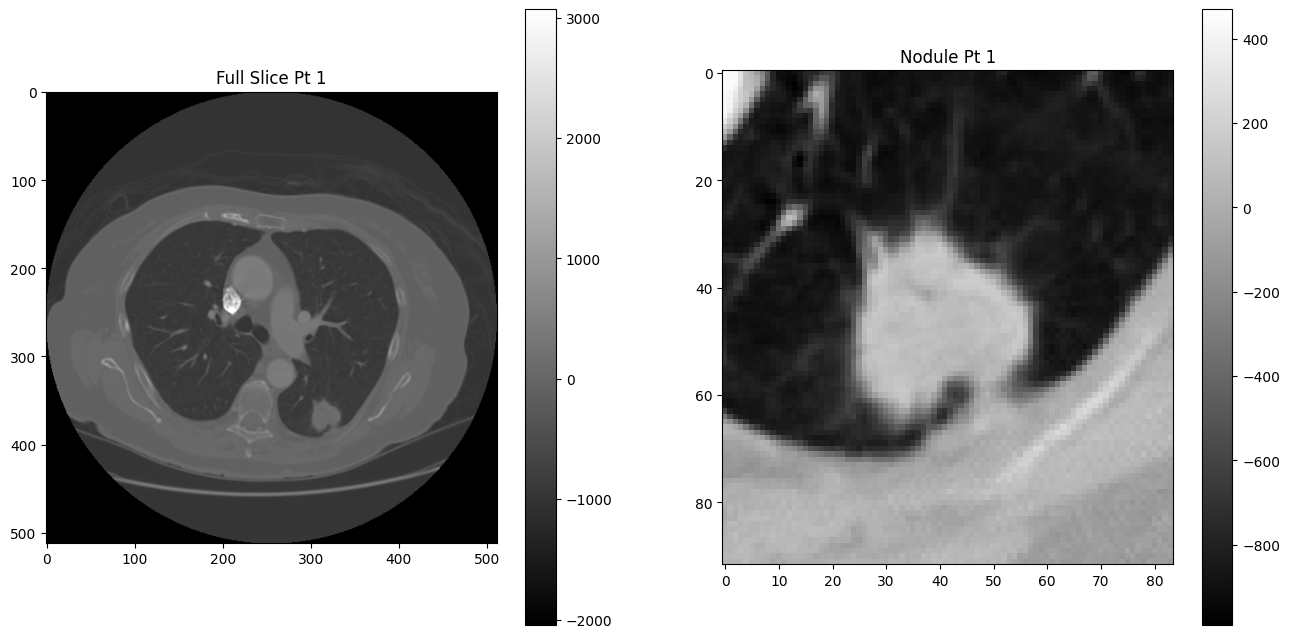

In [ ]:
def load_full_slices(path):
  os.chdir(path)
  files = glob.glob('*fullslice.nrrd')
  images = [nrrd.read(file) for file in files]
  return images

def load_nodules(path):
  os.chdir(path)
  files = glob.glob('*nodule.nrrd')
  images = [nrrd.read(file) for file in files]
  return images

full_slice = "/content/drive/MyDrive/Progetto Applied AI/AI Project 2024-2025/Train/pat1_fullslice.nrrd"
nodule = "/content/drive/MyDrive/Progetto Applied AI/AI Project 2024-2025/Train/pat1_nodule.nrrd"

data, header = nrrd.read(full_slice)
data1, header1 = nrrd.read(nodule)
print("Header del file NRRD:")
print(header)
print("\nForma dei dati:", data.shape)
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='gray')
plt.title('Full Slice Pt 1')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(data1, cmap='gray')
plt.title('Nodule Pt 1')
plt.colorbar()
plt.show()


In [ ]:
# load full slices
full_slices = load_full_slices(dataPath)
print(len(full_slices))

# load nodules
nodules = load_nodules(dataPath)
print(len(nodules))

2363
2363


In [ ]:
headers_slices = [full_slice[1] for full_slice in full_slices]
headers_nodules = [nodule[1] for nodule in nodules]

full_slices_imgs = [full_slice[0] for full_slice in full_slices]
nodules_imgs = [nodule[0] for nodule in nodules]


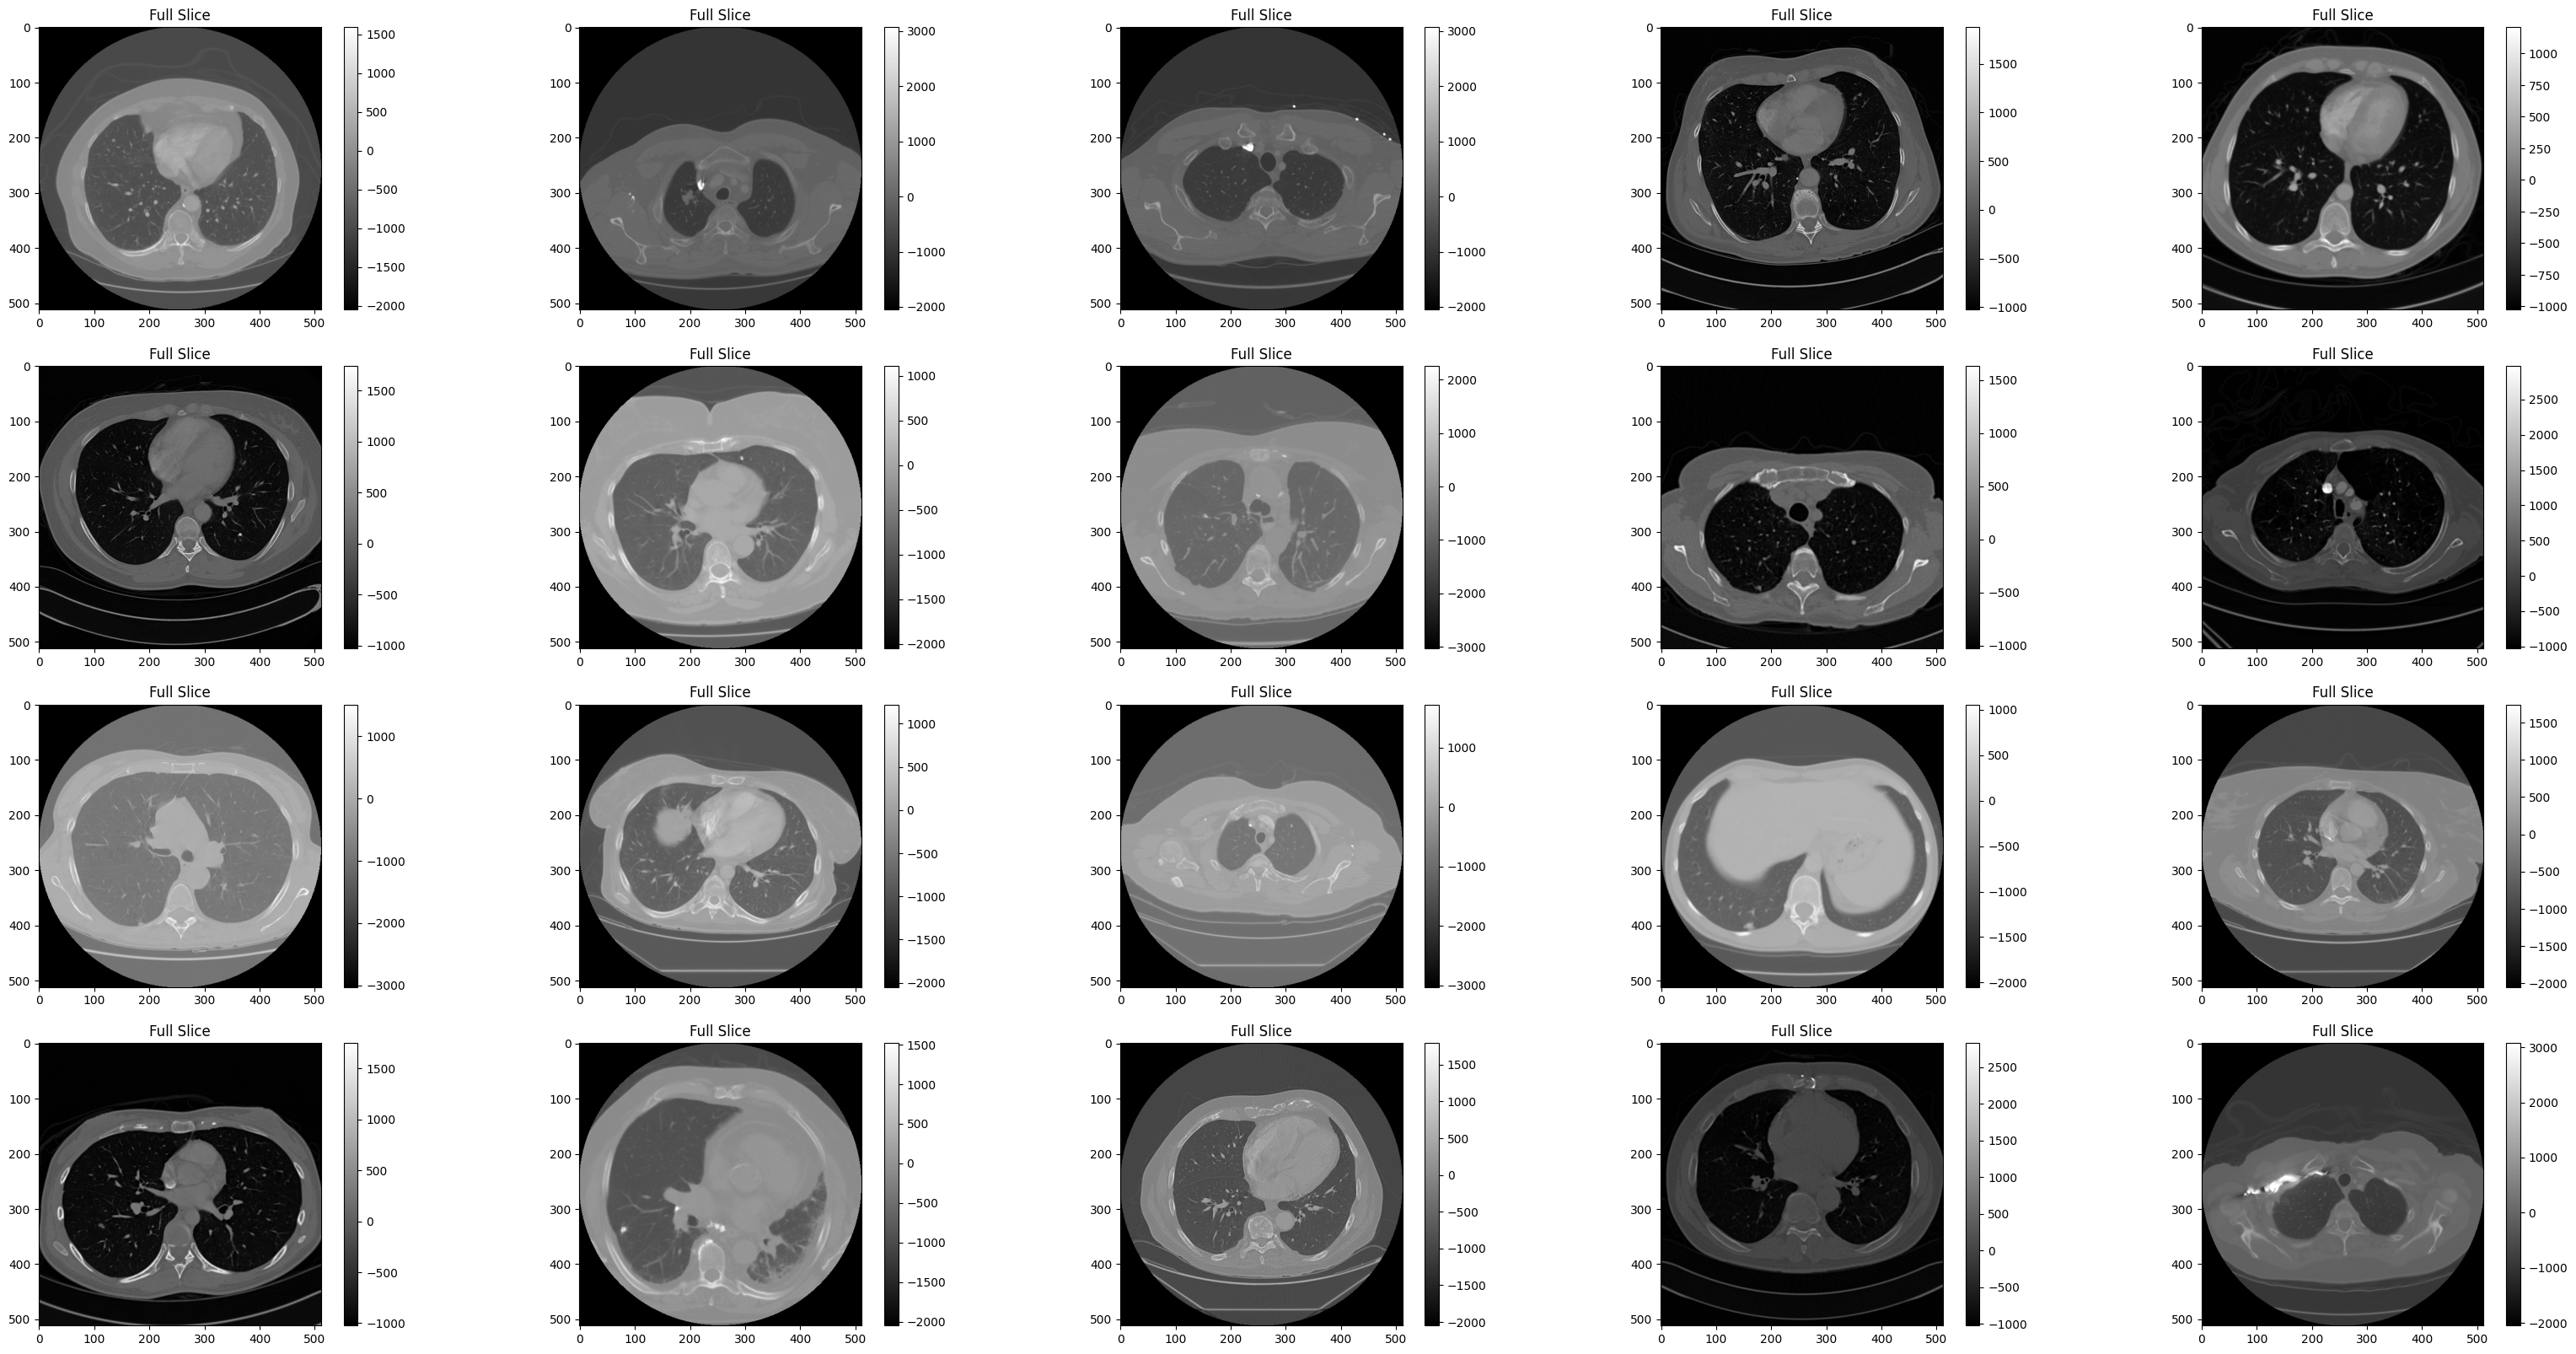

In [ ]:
# Select random images to plot
num_images = 20
random_indices = np.random.choice(len(full_slices), num_images, replace=False)
selected_slices = [full_slices_imgs[i] for i in random_indices]
selected_nodules = [nodules_imgs[i] for i in random_indices]

plt.figure(figsize = (40, 20))
for i in range(num_images):
  plt.subplot(4, 5, i+1)
  plt.imshow(selected_slices[i], cmap='gray')
  plt.title('Full Slice')
  plt.colorbar()


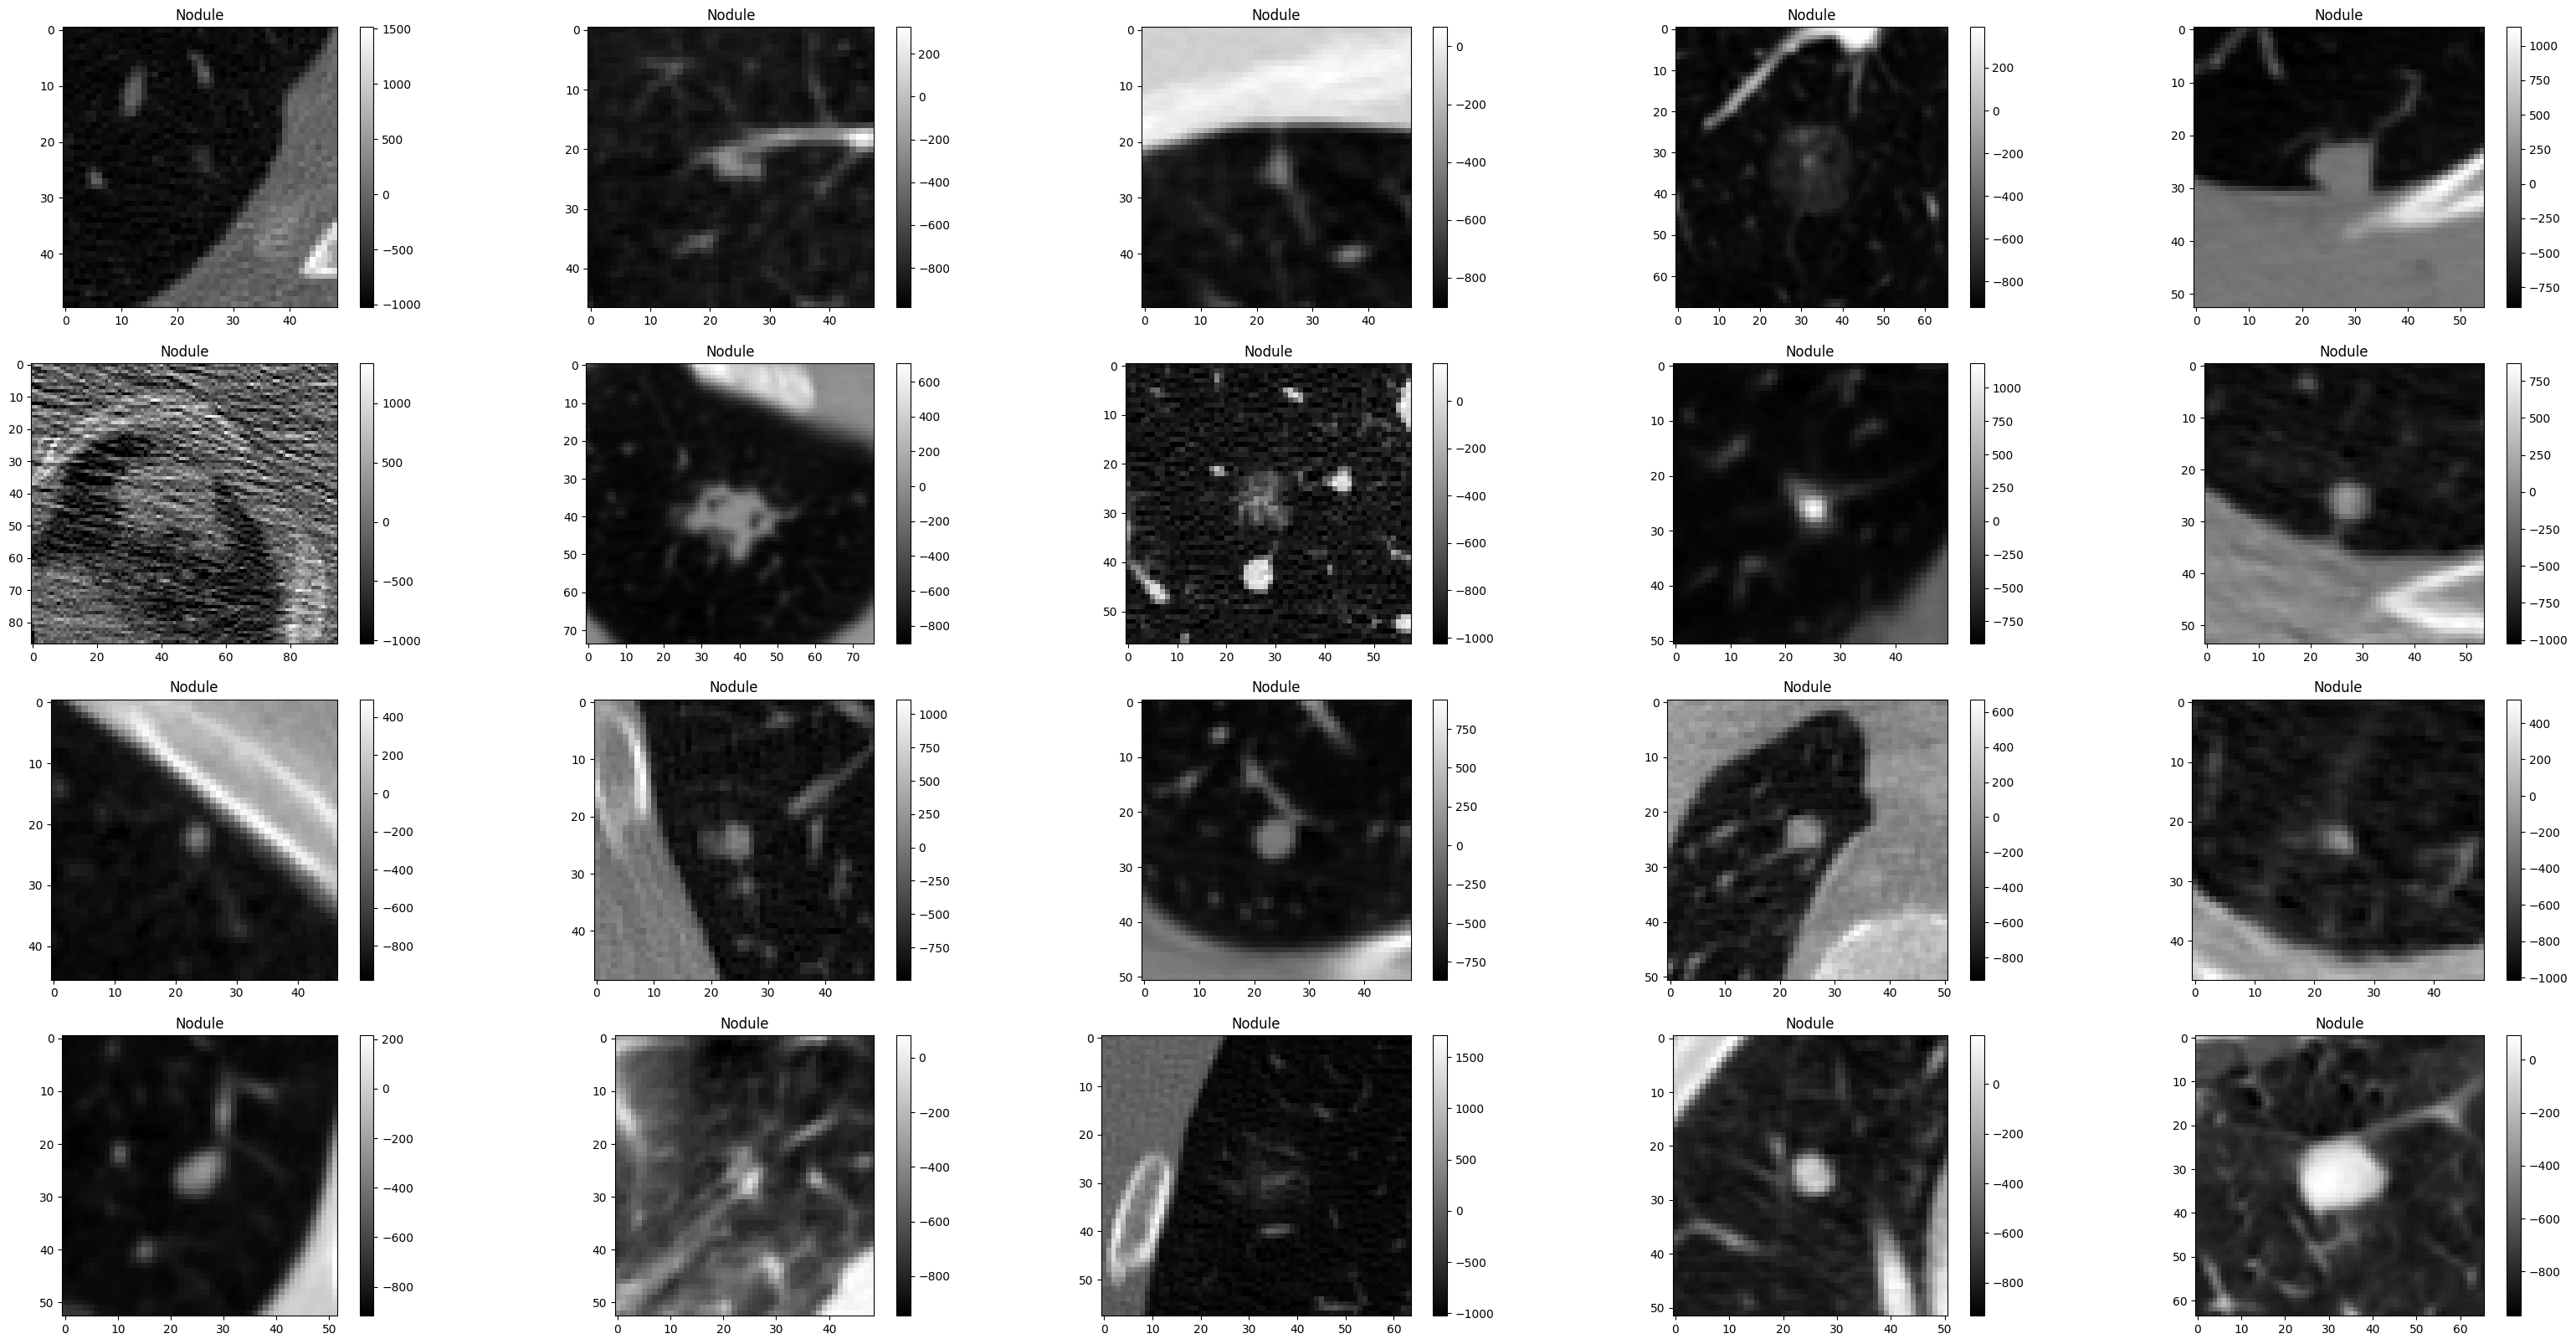

In [ ]:
# nodules images have not all the same size
plt.figure(figsize = (40, 20))
for i in range(num_images):
  plt.subplot(4, 5, i+1)
  plt.imshow(selected_nodules[i], cmap='gray')
  plt.title('Nodule')
  plt.colorbar()

Extract Labels

In [ ]:
# read and load the informative excel file
os.chdir(bpath)
excel_file = glob.glob('**/*.xlsx')
print(excel_file)
df = pd.read_excel(excel_file[0])
df.head()

# add a column with the binary label: if TumorClass = [1, 2, 3]: binary_label = 0, else: binary_label = 1
# extract labels
labels = df['TumorClass'].values
binary_labels = [0 if label in [1, 2, 3] else 1 for label in labels] # 0 = benign, 1 = malignant
df['BinaryLabel'] = binary_labels
df.head()


['AI Project 2024-2025/dataset_lung.xlsx']


,Full_slice,Nodule,TumorClass,BinaryLabel
0,pat1_fullslice.nrrd,pat1_nodule.nrrd,5,1
1,pat2_fullslice.nrrd,pat2_nodule.nrrd,5,1
2,pat3_fullslice.nrrd,pat3_nodule.nrrd,2,0
3,pat4_fullslice.nrrd,pat4_nodule.nrrd,5,1
4,pat5_fullslice.nrrd,pat5_nodule.nrrd,4,1


In [ ]:
print(len(binary_labels))

2363


##**Check Class distributions**
The dataset is umbalanced, so some resampling or class weighting is needed

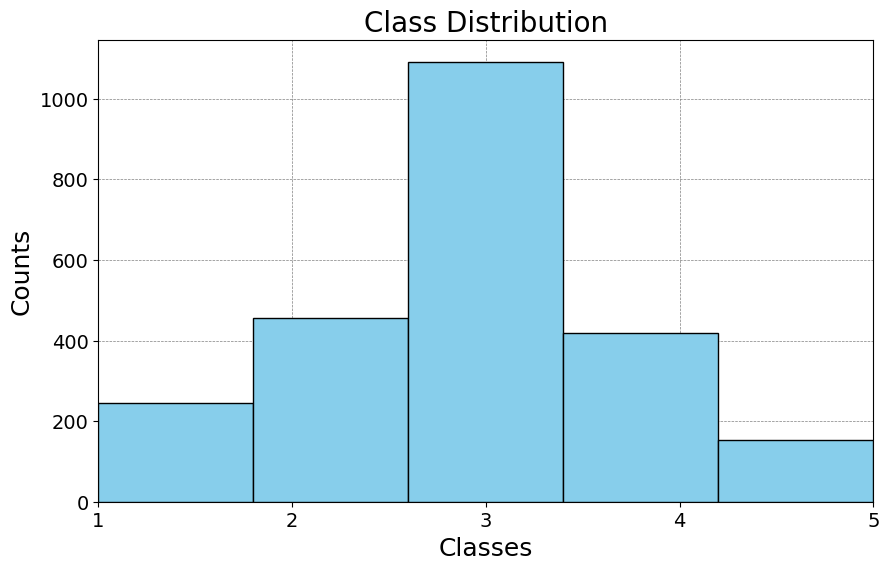

In [ ]:
# Plotting  histogram for multiclass
plt.figure(figsize=(10, 6))
plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, zorder = 0)
plt.hist(labels, bins=5, color='skyblue', edgecolor='black', zorder = 3)
# Adding labels and title
plt.xlabel('Classes', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)
plt.title('Class Distribution', fontsize = 20)
plt.xlim(1, 5)
plt.xticks([1, 2, 3, 4, 5], fontsize=14)
plt.yticks(fontsize=14)

# Display the plot
plt.show()

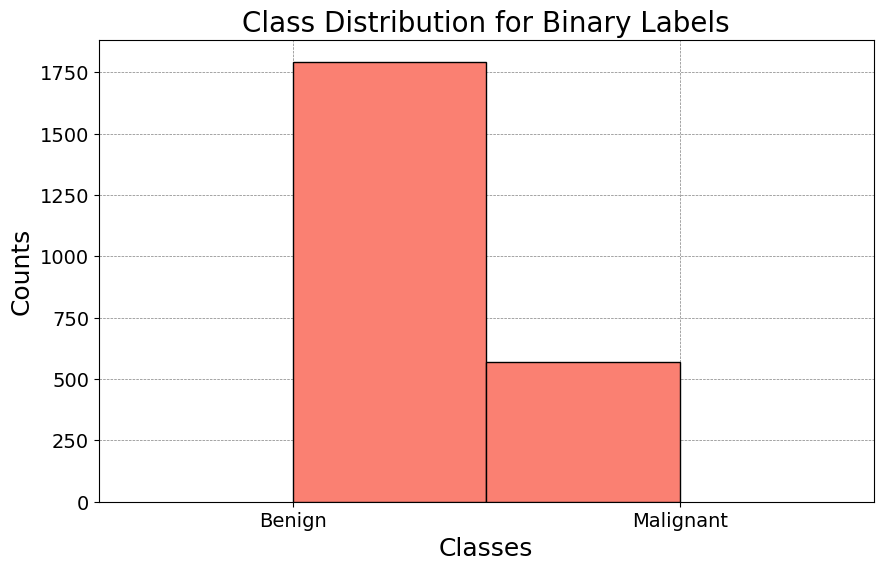

In [ ]:
# Plotting histogram for benign vs malignant
plt.figure(figsize=(10, 6))
plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, zorder = 0)
plt.hist(binary_labels, bins=2, color='salmon', edgecolor='black', zorder = 3)
# Adding labels and title
plt.xlabel('Classes', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)
plt.title('Class Distribution for Binary Labels', fontsize = 20)
plt.xlim(-0.5, 1.5)
plt.xticks([0, 1], labels=['Benign', 'Malignant'], fontsize=14)
plt.yticks(fontsize=14)

# Display the plot
plt.show()

## Check pixel values distribution

In [ ]:
all_pixels = []
for image in full_slices_imgs:
    all_pixels.append(image.flatten())
all_pixels = np.concatenate(all_pixels)



In [ ]:
# show mean and std of the dataset
mean = np.mean(all_pixels)
std = np.std(all_pixels)
print("Mean:", mean)
print("Standard Deviation:", std)

Mean: -783.5035757693606
Standard Deviation: 869.3491398613079


(array([0.0e+00, 5.0e+07, 1.0e+08, 1.5e+08, 2.0e+08, 2.5e+08, 3.0e+08]),
 [Text(0, 0.0, '0.0'),
  Text(0, 50000000.0, '0.5'),
  Text(0, 100000000.0, '1.0'),
  Text(0, 150000000.0, '1.5'),
  Text(0, 200000000.0, '2.0'),
  Text(0, 250000000.0, '2.5'),
  Text(0, 300000000.0, '3.0')])

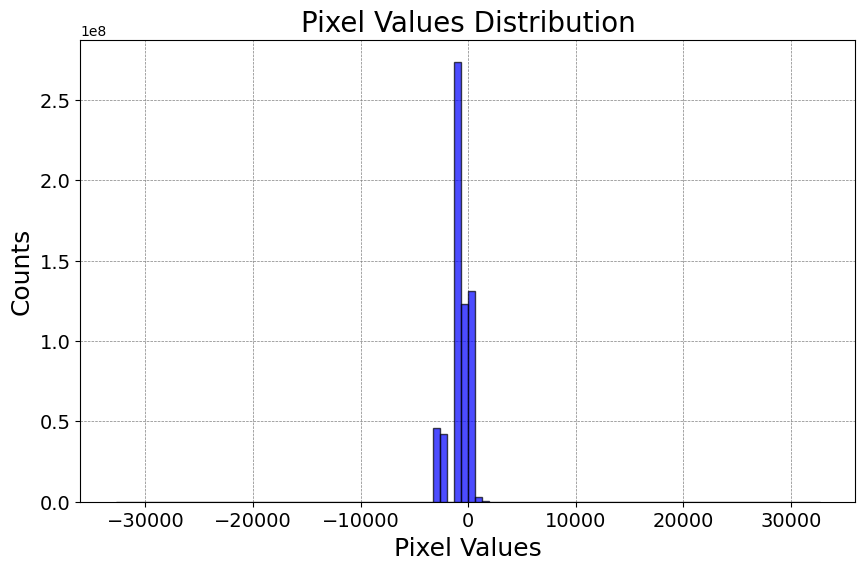

In [ ]:
# Plot histogram
plt.figure(figsize=(10, 6))
hist = plt.hist(all_pixels, bins=100, color='blue', alpha = 0.7, edgecolor='black', zorder = 3)
plt.grid(visible = True, color = 'gray', linestyle = '--', linewidth = 0.5, zorder = 0)
plt.ylabel('Counts', fontsize = 18)
plt.xlabel('Pixel Values', fontsize = 18)
plt.title('Pixel Values Distribution', fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nrrd



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nrrd
from tensorflow.keras.utils import Sequence
import random

class LungImageGenerator(Sequence):
    def __init__(self, image_paths, labels_file, batch_size=32, shuffle = True, augment=False):
        """
        Args:
            image_paths (list): List of paths to the images.
            labels_file (str): Path to the Excel file containing labels.
            batch_size (int): Batch size.
            augment (bool): Whether to apply data augmentation.
        """
        self.image_paths = image_paths
        self.labels, self.binary_labels = self._load_labels(labels_file)
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(self.image_paths))  # To shuffle the dataset
        self.shuffle = shuffle

    def _load_labels(self, labels_file):
        """
        Load labels from the Excel file.
        """
        df = pd.read_excel(labels_file[0])
        labels = df['TumorClass'].values  # extract labels from the excel file
        binary_labels = [0 if label in [1, 2, 3] else 1 for label in labels] # 0 = benign, 1 = malignant

        return labels - 1, binary_labels

    def __len__(self):
        """
        Return the number of batches per epoch.
        """
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        # Generate indexes of the batch
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get image paths and labels for the batch
        batch_paths = [self.image_paths[i] for i in indices]
        batch_multi_labels = np.array([self.labels[i] for i in indices])
        batch_binary_labels = np.array([self.binary_labels[i] for i in indices])

        # Load and preprocess images
        batch_images = np.array([self._load_and_preprocess_image(path) for path in batch_paths])

        return batch_images, {'binary_classification': batch_binary_labels, 'multi_class_classification': batch_multi_labels}

    def _load_and_preprocess_image(self, path):
        """
        Load an image from a path and preprocess it.
        """
        image, _ = nrrd.read(path)  # Read NRRD file
        image = tf.convert_to_tensor(image, dtype=tf.float32)

        # If grayscale, expand to 3 channels
        if len(image.shape) == 2:
            image = tf.expand_dims(image, axis=-1)
            image = tf.repeat(image, repeats=3, axis=-1)

        # Resize and normalize
        image = tf.image.resize(image, (224, 224))  # Resize to 224x224
        image = image / 255.0  # Scale to [0, 1]
        image = (image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]  # Normalize with ImageNet stats (only if using a pretrained model)

        # Apply augmentation if enabled
        if self.augment:
            image = self._apply_augmentation(image)

        return image

    def _apply_augmentation(self, image):
        """
        Apply data augmentation to the image.
        """
        image = tf.image.random_flip_left_right(image)  # Horizontal flip
        image = tf.image.random_brightness(image, max_delta=0.2)  # Brightness adjustment
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Contrast adjustment
        return image

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indices)


In [ ]:
# train generator
train_gen = LungImageGenerator(image_paths = slices_paths, labels_file = excel_file, batch_size=32, augment=True)

# validation generator
val_gen = LungImageGenerator(image_paths=slices_paths, labels_file=excel_file, batch_size=32, augment=False) # during validation no augmentation is applied


##**Da Provare**
- Modello Multimodal, che prende in input  le due imagini e poi concatena in una rappresentazione congiunta
- utilizzare la dilated convolution per dare attenzione a più livelli e attention mechanism


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Create base model
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)
shared_features = GlobalAveragePooling2D()(base_model.output)

# two separate heads: one head for the binary classification task and one head for the multi-class classification task
# two-class head
binary_output = Dense(1, activation='sigmoid', name='binary_classification')(shared_features)

# multi-class head
multi_class_output = Dense(5, activation='softmax', name='multi_class_classification')(shared_features)

# Modello finale
model = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

# Compila il modello con perdite multiple
model.compile(
    optimizer='adam',
    loss={
        'binary_classification': 'binary_crossentropy',
        'multi_class_classification': 'sparse_categorical_crossentropy'
    },
    metrics={
        'binary_classification': 'accuracy',
        'multi_class_classification': 'accuracy'
    }
)


model.fit(train_gen, validation_data=val_gen, epochs=10)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 2108s 28s/step - binary_classification_accuracy: 0.6935 - binary_classification_loss: 0.6953 - loss: 2.4622 - multi_class_classification_accuracy: 0.3746 - multi_class_classification_loss: 1.7681 - val_binary_classification_accuracy: 0.7588 - val_binary_classification_loss: 3.1202 - val_loss: 9.9588 - val_multi_class_classification_accuracy: 0.1930 - val_multi_class_classification_loss: 6.8468
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2006s 27s/step - binary_classification_accuracy: 0.7644 - binary_classification_loss: 0.5587 - loss: 1.9845 - multi_class_classification_accuracy: 0.4619 - multi_class_classification_loss: 1.4255 - val_binary_classification_accuracy: 0.7588 - val_binary_classification_loss: 0.5567 - val_loss: 1.9872 - val_multi_class_classification_accuracy: 0.4469 - val_multi_class_classification_loss: 1.4304
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1995s 27s/step - binary_classification_accuracy: 0.7561 - binary_classification_loss: 0.5654 - loss: 2.